# NB01: Anatomy of the Core Gene Burden

Core genes are MORE likely to be burdens (positive fitness when deleted) than accessory
genes. This seems paradoxical — why would the conserved genome be costly?

**Key insight**: Lab conditions are an impoverished proxy for nature. A gene burdensome
in LB may be essential in soil, biofilm, or host tissue. Genes that are simultaneously
burdensome (lab) AND core (pangenome) are the strongest evidence for purifying selection
in natural environments — nature maintains them despite their lab-measured cost.

All analysis runs locally using cached data from upstream projects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path

FE_DIR = Path('../../fitness_effects_conservation/data')
CONS_DIR = Path('../../conservation_vs_fitness/data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load data
fs = pd.read_csv(FE_DIR / 'fitness_stats.tsv', sep='\t')
by_cond = pd.read_csv(FE_DIR / 'fitness_stats_by_condition.tsv', sep='\t')
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']
seed = pd.read_csv(CONS_DIR / 'seed_annotations.tsv', sep='\t')
hier = pd.read_csv(CONS_DIR / 'seed_hierarchy.tsv', sep='\t')
hier_dedup = hier.drop_duplicates(subset='seed_desc', keep='first')
specpheno = pd.read_csv(FE_DIR / 'specific_phenotypes.tsv', sep='\t')

# Merge fitness + conservation + annotations
m = fs.merge(link[['orgId','locusId','is_core','is_singleton','is_auxiliary','gene_cluster_id']],
             on=['orgId','locusId'], how='left')
m['is_mapped'] = m['gene_cluster_id'].notna()
m['conservation'] = 'unmapped'
m.loc[m['is_mapped'] & (m['is_core'] == True), 'conservation'] = 'core'
m.loc[m['is_mapped'] & (m['is_singleton'] == True), 'conservation'] = 'singleton'
m.loc[m['is_mapped'] & (m['is_core'] != True) & (m['is_singleton'] != True), 'conservation'] = 'auxiliary'

m = m.merge(seed, on=['orgId','locusId'], how='left')
m = m.merge(hier_dedup[['seed_desc','toplevel','category','subsystem']], on='seed_desc', how='left')
m = m.merge(specpheno, on=['orgId','locusId'], how='left')
m['n_specific_phenotypes'] = m['n_specific_phenotypes'].fillna(0).astype(int)
m['is_burden'] = m['n_beneficial'] > 0
m['is_tradeoff'] = (m['n_sick'] > 0) & (m['n_beneficial'] > 0)

mapped = m[m['is_mapped']]
print(f'Genes: {len(m):,} ({len(mapped):,} mapped)')
print(f'Burden genes (fit > 1 in any experiment): {m["is_burden"].sum():,} ({m["is_burden"].mean()*100:.1f}%)')
print(f'Trade-off genes (both sick and beneficial): {m["is_tradeoff"].sum():,}')
print(f'\nNote: This analysis covers genes WITH fitness data only. The 27,693 essential')
print(f'genes (no transposon insertions) are excluded — they have no fitness scores')
print(f'and cannot be classified as burdens or non-burdens.')

Genes: 166,523 (142,190 mapped)
Burden genes (fit > 1 in any experiment): 39,163 (23.5%)
Trade-off genes (both sick and beneficial): 29,458

Note: This analysis covers genes WITH fitness data only. The 27,693 essential
genes (no transposon insertions) are excluded — they have no fitness scores
and cannot be classified as burdens or non-burdens.


## A. Which Functional Categories Drive the Burden Paradox?

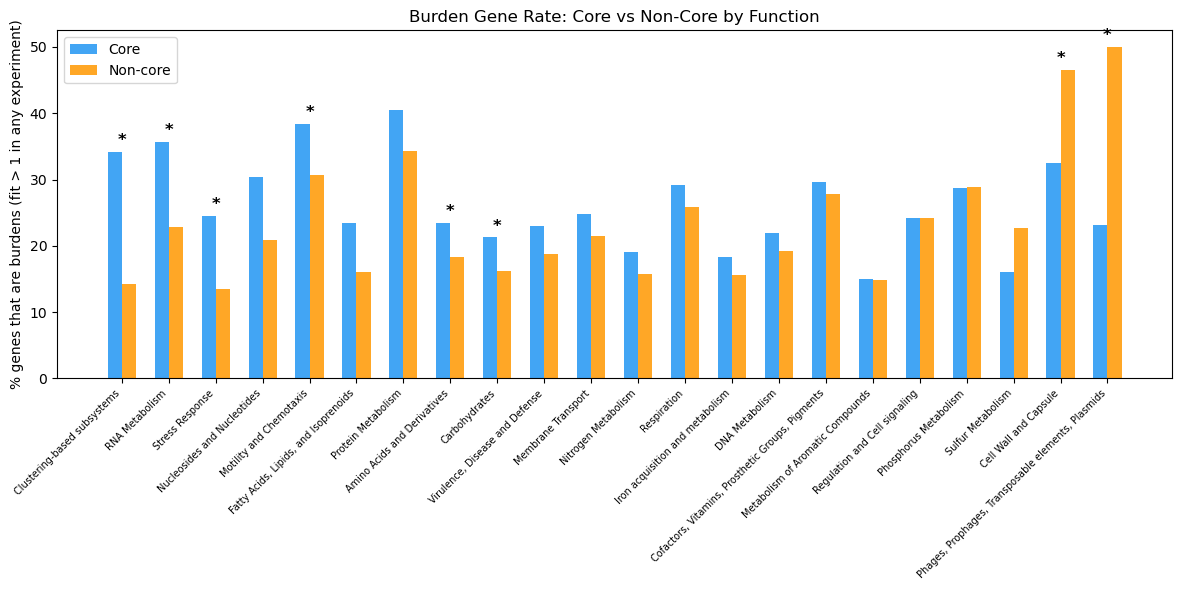

=== BURDEN RATE BY FUNCTION (Fisher exact + BH-FDR) ===
                                          toplevel  core_burden_pct  noncore_burden_pct  diff_pp  odds_ratio  p_adj  significant
                       Clustering-based subsystems            34.17               14.29    19.89        3.11   0.01         True
                                    RNA Metabolism            35.68               22.77    12.90        1.88   0.03         True
                                   Stress Response            24.56               13.48    11.09        2.09   0.00         True
                       Nucleosides and Nucleotides            30.40               20.83     9.57        1.66   0.11        False
                           Motility and Chemotaxis            38.40               30.63     7.77        1.41   0.03         True
              Fatty Acids, Lipids, and Isoprenoids            23.48               16.06     7.42        1.60   0.07        False
                                Protein M

In [2]:
annotated = mapped[mapped['toplevel'].notna()]

burden_by_cat = annotated.groupby(['toplevel', 'is_core']).apply(
    lambda x: pd.Series({
        'burden_rate': (x['is_burden']).mean() * 100,
        'n': len(x),
        'n_burden': x['is_burden'].sum()
    })
).reset_index()

core_burden = burden_by_cat[burden_by_cat['is_core'] == True].set_index('toplevel')
noncore_burden = burden_by_cat[burden_by_cat['is_core'] == False].set_index('toplevel')

# Only categories with enough genes in both groups
min_genes = burden_by_cat.groupby('toplevel')['n'].min()
good_cats = min_genes[min_genes >= 50].index

# Fisher's exact test per category + BH-FDR correction
test_results = []
for cat in good_cats:
    if cat not in core_burden.index or cat not in noncore_burden.index:
        continue
    c = core_burden.loc[cat]
    nc = noncore_burden.loc[cat]
    table = [[int(c['n_burden']), int(c['n'] - c['n_burden'])],
             [int(nc['n_burden']), int(nc['n'] - nc['n_burden'])]]
    odds_r, pval = stats.fisher_exact(table)
    test_results.append({
        'toplevel': cat,
        'core_burden_pct': c['burden_rate'],
        'noncore_burden_pct': nc['burden_rate'],
        'diff_pp': c['burden_rate'] - nc['burden_rate'],
        'odds_ratio': odds_r,
        'p_value': pval,
    })

test_df = pd.DataFrame(test_results).sort_values('diff_pp', ascending=False)
reject, padj, _, _ = multipletests(test_df['p_value'], method='fdr_bh')
test_df['p_adj'] = padj
test_df['significant'] = reject

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(test_df))
ax.bar([i-0.15 for i in x], test_df['core_burden_pct'], 0.3,
       label='Core', color='#2196F3', alpha=0.85)
ax.bar([i+0.15 for i in x], test_df['noncore_burden_pct'], 0.3,
       label='Non-core', color='#FF9800', alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(test_df['toplevel'], rotation=45, ha='right', fontsize=7)
ax.set_ylabel('% genes that are burdens (fit > 1 in any experiment)')
ax.set_title('Burden Gene Rate: Core vs Non-Core by Function')
ax.legend()

# Mark significant categories
for i, row in enumerate(test_df.itertuples()):
    if row.significant:
        ax.text(i, max(row.core_burden_pct, row.noncore_burden_pct) + 1, '*',
                ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'burden_by_function.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== BURDEN RATE BY FUNCTION (Fisher exact + BH-FDR) ===')
print(test_df[['toplevel','core_burden_pct','noncore_burden_pct','diff_pp','odds_ratio','p_adj','significant']].round(2).to_string(index=False))
print(f'\nSignificant (BH-FDR q<0.05): {test_df["significant"].sum()}/{len(test_df)}')

## B. Which Condition Types Make Core Genes Burdensome?

Note: `n_beneficial` in `fitness_stats_by_condition.tsv` counts the number of experiments
*within that condition type* where the gene showed positive fitness (fit > 1), not the
overall count across all experiments.

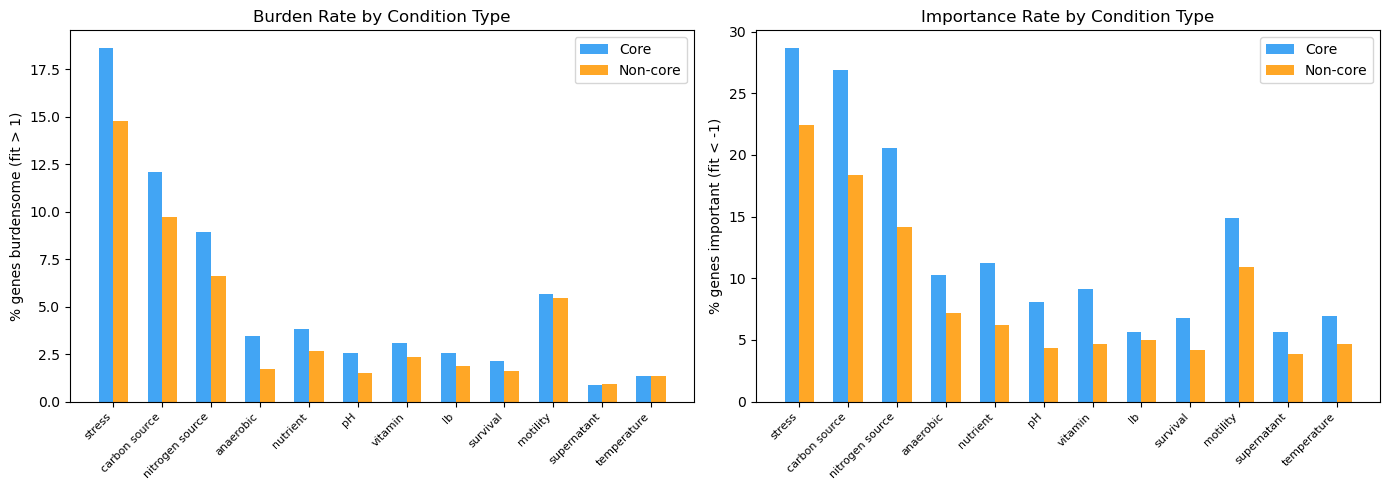

=== BURDEN AND IMPORTANCE BY CONDITION TYPE ===
      condition  core_burden  noncore_burden  core_sick  noncore_sick  burden_diff  sick_diff
         stress         18.6            14.8       28.7          22.4          3.9        6.3
  carbon source         12.1             9.7       26.9          18.4          2.3        8.5
nitrogen source          8.9             6.6       20.6          14.1          2.3        6.5
      anaerobic          3.5             1.7       10.2           7.2          1.8        3.1
       nutrient          3.8             2.6       11.2           6.2          1.2        5.0
             pH          2.6             1.5        8.1           4.4          1.1        3.8
        vitamin          3.1             2.3        9.2           4.6          0.7        4.5
             lb          2.6             1.9        5.7           5.0          0.7        0.7
       survival          2.1             1.6        6.8           4.2          0.5        2.6
       motil

In [3]:
# Add conservation to condition-level data
bc = by_cond.merge(link[['orgId','locusId','is_core','gene_cluster_id']],
                    on=['orgId','locusId'], how='left')
bc['is_mapped'] = bc['gene_cluster_id'].notna()
bc_mapped = bc[bc['is_mapped']]

# Top condition types
top_conds = by_cond['expGroup'].value_counts().head(12).index.tolist()

cond_burden = []
for cond in top_conds:
    d = bc_mapped[bc_mapped['expGroup'] == cond]
    core_d = d[d['is_core'] == True]
    noncore_d = d[d['is_core'] != True]
    if len(core_d) < 100 or len(noncore_d) < 50:
        continue
    cond_burden.append({
        'condition': cond,
        'core_burden': (core_d['n_beneficial'] > 0).mean() * 100,
        'noncore_burden': (noncore_d['n_beneficial'] > 0).mean() * 100,
        'core_sick': (core_d['n_sick'] > 0).mean() * 100,
        'noncore_sick': (noncore_d['n_sick'] > 0).mean() * 100,
    })

cb = pd.DataFrame(cond_burden)
cb['burden_diff'] = cb['core_burden'] - cb['noncore_burden']
cb['sick_diff'] = cb['core_sick'] - cb['noncore_sick']
cb = cb.sort_values('burden_diff', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = range(len(cb))
axes[0].bar([i-0.15 for i in x], cb['core_burden'], 0.3, label='Core', color='#2196F3', alpha=0.85)
axes[0].bar([i+0.15 for i in x], cb['noncore_burden'], 0.3, label='Non-core', color='#FF9800', alpha=0.85)
axes[0].set_xticks(x)
axes[0].set_xticklabels(cb['condition'], rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('% genes burdensome (fit > 1)')
axes[0].set_title('Burden Rate by Condition Type')
axes[0].legend()

axes[1].bar([i-0.15 for i in x], cb['core_sick'], 0.3, label='Core', color='#2196F3', alpha=0.85)
axes[1].bar([i+0.15 for i in x], cb['noncore_sick'], 0.3, label='Non-core', color='#FF9800', alpha=0.85)
axes[1].set_xticks(x)
axes[1].set_xticklabels(cb['condition'], rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('% genes important (fit < -1)')
axes[1].set_title('Importance Rate by Condition Type')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'burden_by_condition.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== BURDEN AND IMPORTANCE BY CONDITION TYPE ===')
print(cb.round(1).to_string(index=False))

## C. Trade-Off Genes — Both Sick AND Beneficial

=== TRADE-OFF GENES vs CONSERVATION ===
conservation  core  auxiliary  singleton
is_tradeoff                             
False         80.1       15.4        4.6
True          83.8       12.4        3.8

Trade-off genes: 25,271 / 142,190
Trade-off vs core: OR=1.29, p=1.20e-44


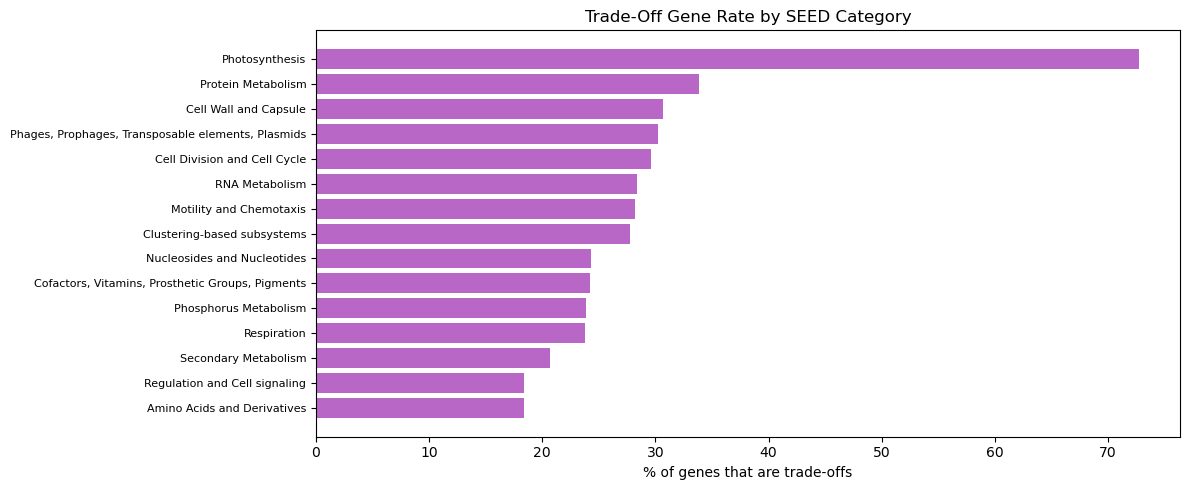

In [4]:
# Trade-off genes: sick in some conditions, beneficial in others
tradeoff_cons = pd.crosstab(mapped['is_tradeoff'], mapped['conservation'],
                             normalize='index') * 100
cat_order = ['core', 'auxiliary', 'singleton']
tradeoff_cons = tradeoff_cons[[c for c in cat_order if c in tradeoff_cons.columns]]

print('=== TRADE-OFF GENES vs CONSERVATION ===')
print(tradeoff_cons.round(1).to_string())
print(f'\nTrade-off genes: {mapped["is_tradeoff"].sum():,} / {len(mapped):,}')

# Fisher's exact: are trade-off genes more core?
to_core = mapped[mapped['is_tradeoff'] & (mapped['is_core'] == True)].shape[0]
to_not = mapped[mapped['is_tradeoff'] & (mapped['is_core'] != True)].shape[0]
nto_core = mapped[~mapped['is_tradeoff'] & (mapped['is_core'] == True)].shape[0]
nto_not = mapped[~mapped['is_tradeoff'] & (mapped['is_core'] != True)].shape[0]
odds, p = stats.fisher_exact([[to_core, to_not], [nto_core, nto_not]])
print(f'Trade-off vs core: OR={odds:.2f}, p={p:.2e}')

# Which functions produce trade-offs?
tradeoff_annotated = mapped[mapped['is_tradeoff'] & mapped['toplevel'].notna()]
tradeoff_by_func = tradeoff_annotated.groupby('toplevel').size().sort_values(ascending=False)
total_by_func = mapped[mapped['toplevel'].notna()].groupby('toplevel').size()
tradeoff_rate = (tradeoff_by_func / total_by_func * 100).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
tr = tradeoff_rate.dropna().head(15)
ax.barh(range(len(tr)), tr.values, color='#9C27B0', alpha=0.7)
ax.set_yticks(range(len(tr)))
ax.set_yticklabels(tr.index, fontsize=8)
ax.set_xlabel('% of genes that are trade-offs')
ax.set_title('Trade-Off Gene Rate by SEED Category')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'tradeoff_genes_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

## D. The Condition-Specific Paradox

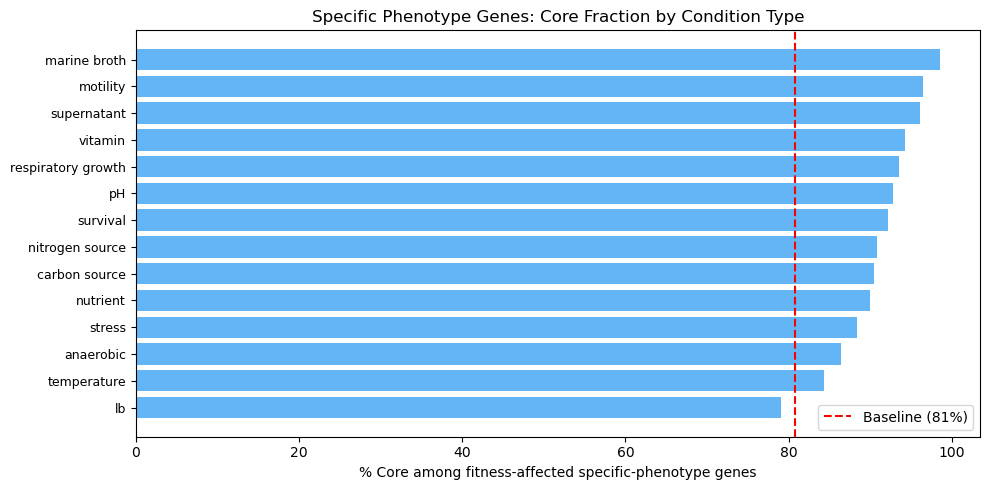

=== SPECIFIC PHENOTYPE GENES BY CONDITION TYPE ===
                    non_core  core  total  pct_core
expGroup                                           
marine broth               1    64     65      98.5
motility                  15   418    433      96.5
supernatant                2    49     51      96.1
vitamin                    7   114    121      94.2
respiratory growth        11   157    168      93.5
pH                        15   193    208      92.8
survival                  10   117    127      92.1
nitrogen source          225  2233   2458      90.8
carbon source            393  3727   4120      90.5
nutrient                  28   253    281      90.0
stress                   527  4017   4544      88.4
anaerobic                 14    89    103      86.4
temperature               21   113    134      84.3
lb                        13    49     62      79.0


In [5]:
# Which conditions produce specific phenotypes in core vs accessory?
# Load specificphenotype with experiment info
# We need experiment -> expGroup mapping
sp_cond = by_cond.merge(link[['orgId','locusId','is_core','gene_cluster_id']],
                         on=['orgId','locusId'], how='inner')
sp_cond = sp_cond[sp_cond['gene_cluster_id'].notna()]

# Genes with specific phenotypes that are also in condition data
has_sp = m[m['n_specific_phenotypes'] > 0][['orgId','locusId']].drop_duplicates()
sp_genes = sp_cond.merge(has_sp, on=['orgId','locusId'], how='inner')

# For specific-phenotype genes, which condition types have fitness effects?
sp_sick = sp_genes[sp_genes['n_sick'] > 0]

sp_by_cond = sp_sick.groupby(['expGroup', 'is_core']).size().unstack(fill_value=0)
if True in sp_by_cond.columns and False in sp_by_cond.columns:
    sp_by_cond.columns = ['non_core', 'core']
    sp_by_cond['total'] = sp_by_cond.sum(axis=1)
    sp_by_cond['pct_core'] = (sp_by_cond['core'] / sp_by_cond['total'] * 100).round(1)
    sp_by_cond = sp_by_cond[sp_by_cond['total'] >= 50].sort_values('pct_core', ascending=False)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(range(len(sp_by_cond)), sp_by_cond['pct_core'], color='#2196F3', alpha=0.7)
    ax.axvline(x=mapped['is_core'].mean() * 100, color='red', linestyle='--',
               label=f'Baseline ({mapped["is_core"].mean()*100:.0f}%)')
    ax.set_yticks(range(len(sp_by_cond)))
    ax.set_yticklabels(sp_by_cond.index, fontsize=9)
    ax.set_xlabel('% Core among fitness-affected specific-phenotype genes')
    ax.set_title('Specific Phenotype Genes: Core Fraction by Condition Type')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'specific_phenotype_conditions.png', dpi=150, bbox_inches='tight')
    plt.show()

    print('=== SPECIFIC PHENOTYPE GENES BY CONDITION TYPE ===')
    print(sp_by_cond.to_string())

## E. Flagellar Motility — Case Study

Motility genes: 2,133
  Core: 86.7%
  Burden (fit > 1): 37.4%
  Trade-off: 28.2%

Non-motility annotated genes:
  Core: 88.0%
  Burden: 24.7%
  Trade-off: 19.6%


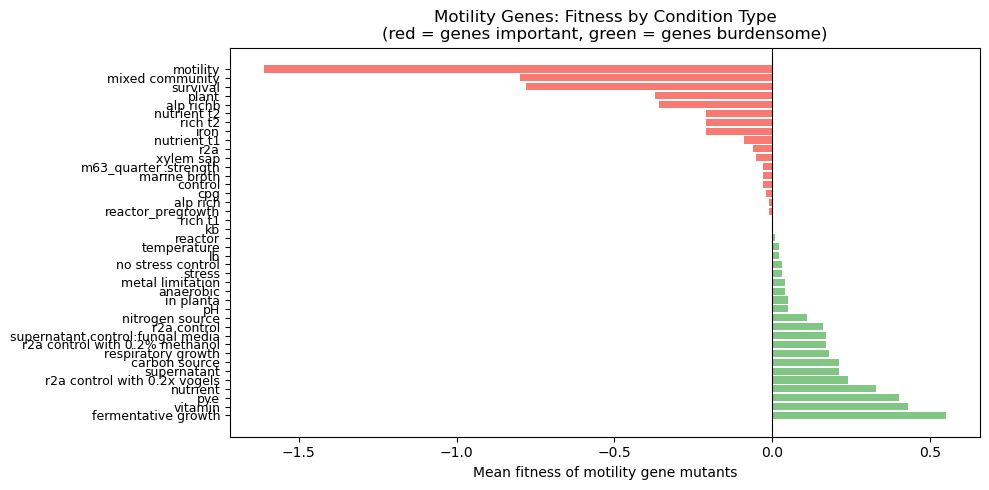

=== MOTILITY GENE FITNESS BY CONDITION ===
                                  mean_fit  pct_sick  pct_beneficial  n_genes
expGroup                                                                     
motility                             -1.61     51.07            6.43      607
mixed community                      -0.80     28.57            4.76       21
survival                             -0.78     52.70            1.35       74
plant                                -0.37     38.87            9.06      265
alp richb                            -0.36     20.88            0.00       91
nutrient t2                          -0.21     24.39           12.20       41
rich t2                              -0.21     17.07           17.07       41
iron                                 -0.21     19.51            2.44       41
nutrient t1                          -0.09     19.51            9.76       41
r2a                                  -0.06      0.00            0.00       79
xylem sap            

In [6]:
# Motility genes: classic trade-off example
motility = mapped[mapped['toplevel'] == 'Motility and Chemotaxis']
non_motility = mapped[mapped['toplevel'].notna() & (mapped['toplevel'] != 'Motility and Chemotaxis')]

print(f'Motility genes: {len(motility):,}')
print(f'  Core: {(motility["is_core"] == True).mean()*100:.1f}%')
print(f'  Burden (fit > 1): {motility["is_burden"].mean()*100:.1f}%')
print(f'  Trade-off: {motility["is_tradeoff"].mean()*100:.1f}%')
print(f'\nNon-motility annotated genes:')
print(f'  Core: {(non_motility["is_core"] == True).mean()*100:.1f}%')
print(f'  Burden: {non_motility["is_burden"].mean()*100:.1f}%')
print(f'  Trade-off: {non_motility["is_tradeoff"].mean()*100:.1f}%')

# Motility fitness by condition type — use merge instead of slow row-wise apply
mot_keys = motility[['orgId', 'locusId']].drop_duplicates()
mot_keys['locusId'] = mot_keys['locusId'].astype(str)
by_cond['locusId'] = by_cond['locusId'].astype(str)
mot_cond = by_cond.merge(mot_keys, on=['orgId', 'locusId'], how='inner')

mot_summary = mot_cond.groupby('expGroup').agg(
    mean_fit=('mean_fit', 'mean'),
    pct_sick=('n_sick', lambda x: (x > 0).mean() * 100),
    pct_beneficial=('n_beneficial', lambda x: (x > 0).mean() * 100),
    n_genes=('locusId', 'nunique')
).round(2)
mot_summary = mot_summary[mot_summary['n_genes'] >= 20].sort_values('mean_fit')

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#F44336' if v < 0 else '#4CAF50' for v in mot_summary['mean_fit']]
ax.barh(range(len(mot_summary)), mot_summary['mean_fit'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_yticks(range(len(mot_summary)))
ax.set_yticklabels(mot_summary.index, fontsize=9)
ax.set_xlabel('Mean fitness of motility gene mutants')
ax.set_title('Motility Genes: Fitness by Condition Type\n(red = genes important, green = genes burdensome)')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'motility_case_study.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== MOTILITY GENE FITNESS BY CONDITION ===')
print(mot_summary.to_string())

## F. Lab Burden + Pangenome Core = Natural Selection Signature

=== SELECTION SIGNATURE MATRIX ===
  Costly + Conserved (strong natural selection):      28,017
  Costly + Dispensable (candidates for gene loss):     5,526
  Neutral + Conserved (housekeeping):                 86,761
  Neutral + Dispensable (niche-specific):              21,886


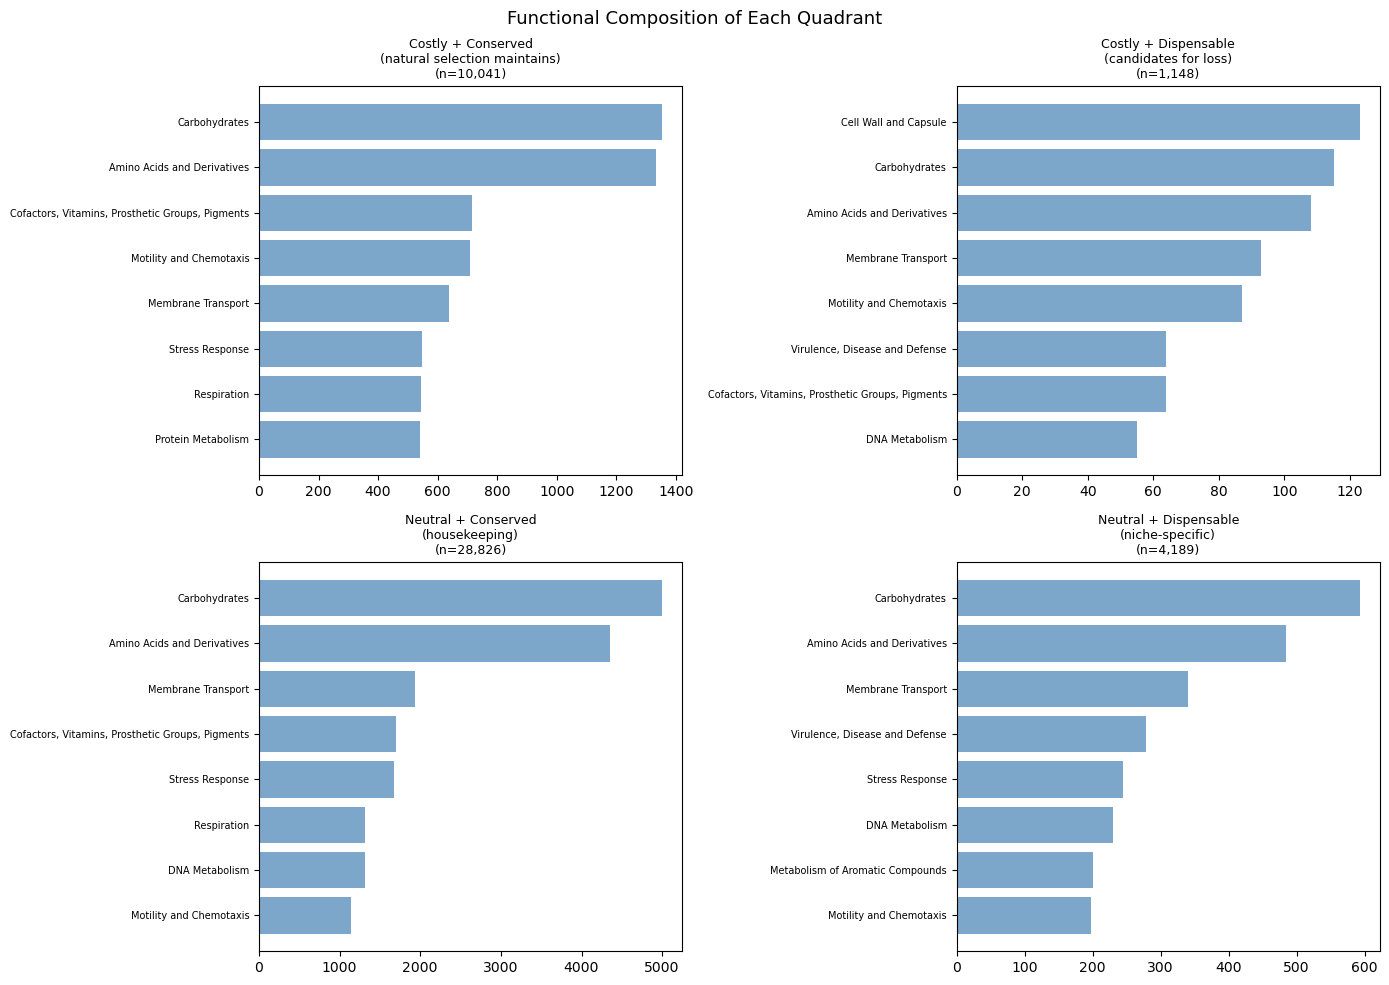

In [7]:
# 2x2: burden × core
mapped_c = mapped.copy()
mapped_c['quadrant'] = 'neutral_core'
mapped_c.loc[mapped_c['is_burden'] & (mapped_c['is_core'] == True), 'quadrant'] = 'costly_conserved'
mapped_c.loc[mapped_c['is_burden'] & (mapped_c['is_core'] != True), 'quadrant'] = 'costly_dispensable'
mapped_c.loc[~mapped_c['is_burden'] & (mapped_c['is_core'] == True), 'quadrant'] = 'neutral_conserved'
mapped_c.loc[~mapped_c['is_burden'] & (mapped_c['is_core'] != True), 'quadrant'] = 'neutral_dispensable'

quad_counts = mapped_c['quadrant'].value_counts()
print('=== SELECTION SIGNATURE MATRIX ===')
print(f'  Costly + Conserved (strong natural selection):    {quad_counts.get("costly_conserved",0):>8,}')
print(f'  Costly + Dispensable (candidates for gene loss):  {quad_counts.get("costly_dispensable",0):>8,}')
print(f'  Neutral + Conserved (housekeeping):               {quad_counts.get("neutral_conserved",0):>8,}')
print(f'  Neutral + Dispensable (niche-specific):            {quad_counts.get("neutral_dispensable",0):>8,}')

# Functional enrichment of each quadrant
quad_annotated = mapped_c[mapped_c['toplevel'].notna()]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
quadrants = ['costly_conserved', 'costly_dispensable', 'neutral_conserved', 'neutral_dispensable']
titles = ['Costly + Conserved\n(natural selection maintains)',
           'Costly + Dispensable\n(candidates for loss)',
           'Neutral + Conserved\n(housekeeping)',
           'Neutral + Dispensable\n(niche-specific)']

for ax, quad, title in zip(axes.flatten(), quadrants, titles):
    qd = quad_annotated[quad_annotated['quadrant'] == quad]
    top_funcs = qd['toplevel'].value_counts().head(8)
    ax.barh(range(len(top_funcs)), top_funcs.values, color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(top_funcs)))
    ax.set_yticklabels(top_funcs.index, fontsize=7)
    ax.set_title(f'{title}\n(n={len(qd):,})', fontsize=9)
    ax.invert_yaxis()

plt.suptitle('Functional Composition of Each Quadrant', fontsize=13)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'selection_signature_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
print('=' * 60)
print('NB01 SUMMARY: Core Gene Burden Anatomy')
print('=' * 60)
print(f'Genes analyzed: {len(mapped):,}')
print(f'Burden genes: {mapped["is_burden"].sum():,} ({mapped["is_burden"].mean()*100:.1f}%)')
print(f'Trade-off genes: {mapped["is_tradeoff"].sum():,} ({mapped["is_tradeoff"].mean()*100:.1f}%)')
print(f'Trade-off vs core: OR={odds:.2f}, p={p:.2e}')
print(f'\nSelection signature:')
for q in quadrants:
    n = quad_counts.get(q, 0)
    print(f'  {q:30s} {n:>8,}')
print('=' * 60)

NB01 SUMMARY: Core Gene Burden Anatomy
Genes analyzed: 142,190
Burden genes: 33,543 (23.6%)
Trade-off genes: 25,271 (17.8%)
Trade-off vs core: OR=1.29, p=1.20e-44

Selection signature:
  costly_conserved                 28,017
  costly_dispensable                5,526
  neutral_conserved                86,761
  neutral_dispensable              21,886
